# Bienvenue sur le notebook du groupe DEEP BRIDGE! 
Pour le test de nos modeles, désolé pas de vidéo de démo... (les modèles sont un peu long à faire tourner!)
Cependant, nous avons crée un notebook interactif et sympa qui vous permet de construire de A à Z un processus de deep learning pour
la segmentation en utilisant un U-net! 

### Segmentation de la matière grise dans la moelle épinière avec PyTorch

Dans ce notebook nous allons créer un modèle qui permet de segmenter la matière grise sur des images IRM de moelle épinière. Pour cela nous utilisons le jeu de données public *GM Spinal Cord Challenge Dataset* [à télécharger ici](http://niftyweb.cs.ucl.ac.uk/challenge/index.php#citation).


![Texte alternatif…](https://docs.google.com/drawings/d/e/2PACX-1vQmKTAQEz_zoomKa0HchswOUunHQTO3gDoH_VnXfcZdl8N3H0L-aGvM9GqQiiLi-bL0ME4-IoU6cv7g/pub?w=928&h=499)

Exemple de tranches d'IRM issues du dataset GMSC

Le jeu de données est composé de 11 patients, et plus de 1000 images. Pour chaque patient, le jeu de données contient des images IRM et des masques de segmentation. C'est ces masques qui permettront de construire un modèle d'apprentissage supervisé. A partir de ces données, notre modèle va apprendre à segmenter la matière grise sur de nouvelles images.

Nous allons utiliser et explorer la libraire [*MedicalTorch*](https://github.com/perone/medicaltorch) qui permet d'appliquer de pré-traiter des images médicales, de les transformer, ainsi que de les charger pour la segmentation.

# Prérequis et installations

Pas de pré-requis pour ce notebook, à part avoir `pip` installé pour télécharger les librairies par ligne de commandes. Pensez à passer le notebook en mode GPU pour la suite! 
(Modifier -> Paramètres du notebook -> Accelerateur matériel = GPU)

### Import des données depuis Google drive

Après avoir téléchargé le jeu de données, la premiere étape de est de l'importer sur son drive Google. Pour que le notebook puisse avoir accès aux données se trouvant sur Google drive, il faut *Mount* le drive. 

La commande ci dessous va retourner un lien de redirection vers une page d'authentification Google. Après avoir autorisé l'accès, il suffira de copier et coller ci dessous le jeton que vous obtiendrez.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Pensez également à créer un répertoire "models" dans votre drive, qui acceuillera le modèle que nous allons créer.

### Installation des librairies
Commençons par installer `PyTorch`, `medicaltorch`, et quelques librairies utiles.

In [0]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
!pip install torchvision
!pip install medicaltorch
!pip install numpy==1.14.1
!pip install 

### Import des librairies
Avant de se lancer, importons toutes les librairies et fonctions dont nous avons besoin.

Nous importons une a une chaque fonction de `medicaltorch` pour traiter et analyser nos images médicales, `numpy` pour la manipulation des tableaux, `nibabel` pour la lecture d'images nifty, `torch` et `torchvision` pour la construction et l'entrainement de notre modèle.

In [2]:
from collections import defaultdict
import time
import os
import numpy as np
from tqdm import tqdm
import nibabel as nib

!pip install medicaltorch
from medicaltorch import datasets as mt_datasets
from medicaltorch import models as mt_models
from medicaltorch import transforms as mt_transforms
from medicaltorch import losses as mt_losses
from medicaltorch import metrics as mt_metrics
from medicaltorch import filters as mt_filters

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn

import torchvision.utils as vutils

cudnn.benchmark = True
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9)

# Exploration du jeu de données

Avant de commencer à créer des modèles d'apprentissage basés sur notre jeu de données, commencons par observer les images qui le composent. 

**Première étape:** importer le chemin du repertoire où se trouvent nos données.

In [0]:
directory = "/content/drive/My Drive/Medical/TPT/GMSpinCord/"

**Deuxième étape:** regardons de plus près à quoi ressemble une image IRM issue du dataset. La librairie `nibabel` permet de lire des images au format nifty, pour les afficher dans notre notebook, il suffit de les transformer en `numpy array`.

Pour commencer, importons une image et un masque associé, et regardons leurs dimensions

In [4]:
test_image = nib.load(directory + 'site1-sc01-image.nii.gz')
test_image_data = test_image.get_fdata()
print(test_image_data.shape)

test_masque = nib.load(directory + 'site1-sc01-mask-r1.nii.gz')
test_masque_data = test_masque.get_fdata()
print(test_masque_data.shape)

(100, 100, 3)
(100, 100, 3)


Le résultat du `shape` nous dit que chaque image est de dimension 100x100, et comporte 3 tranches. Essayons de tracer la tranche centrale des deux images à partir des images nifty que nous avosn transformé en `numpy arrays`.

Text(0.5, 0.98, "Tranche d'IRM et masque de segmentation associé")

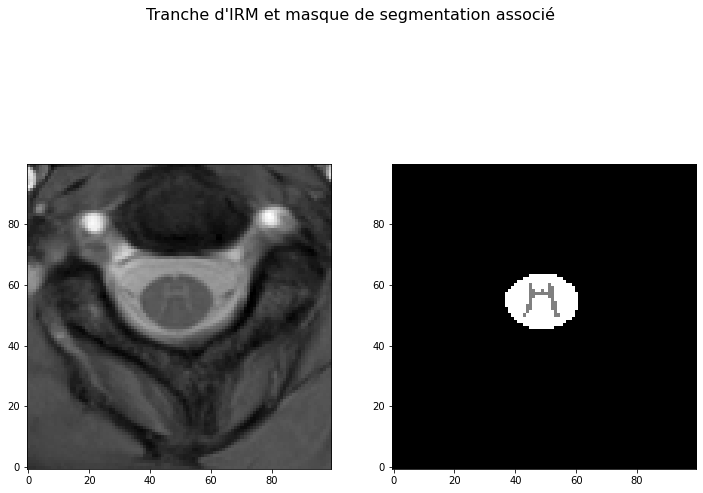

In [5]:
slice_image= test_image_data[:, :, 2]
slice_masque = test_masque_data[:, :, 2]
fig, axes = plt.subplots(1, 2)
axes[0].imshow(slice_image.T, cmap="gray", origin="lower")
axes[1].imshow(slice_masque.T, cmap="gray", origin="lower")
fig.suptitle("Tranche d'IRM et masque de segmentation associé", fontsize=16)

Super!

Pour associer des images et leurs masques ensemble de cette maniere,il existe un module dans `medicaltorch`: `mt_datasets.SegmentationPair2D`. Cette fonction permet de lire les images nifti et les formatter dans un format plus facile à lire pour nous.

In [0]:
image_IRM = os.path.join(directory,'site1-sc01-image.nii.gz')
masque_IRM = os.path.join(directory,'site1-sc01-mask-r1.nii.gz')

pair = mt_datasets.SegmentationPair2D(image_IRM, masque_IRM)
slice_pair = pair.get_pair_slice(2)
tranche_image = slice_pair["input"]
tranche_masque = slice_pair["gt"]

In [7]:
print(tranche_image.shape)

(100, 100)


Comme on peut le voir, `shape` nous renvoie maintenant une image de dimension 100x100, mais grace au module ci dessus, l'image a été automatiquement formattée pour ne renvoyer qu'une tranche.

Text(0.5, 0.98, "Tranche d'IRM et masque de segmentation associé")

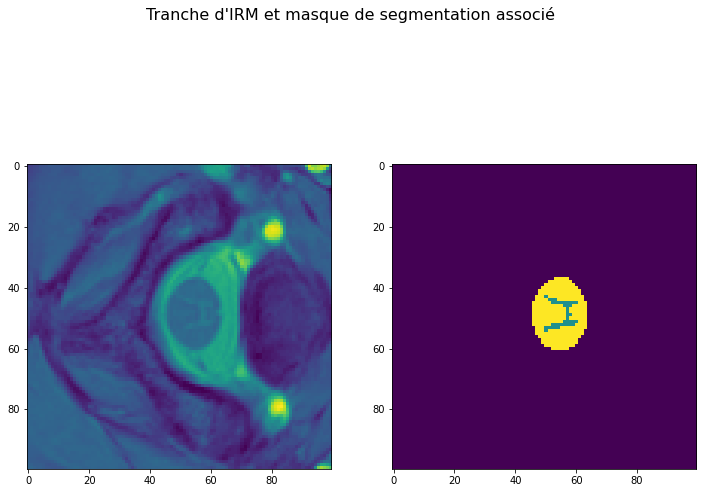

In [8]:
fig, axes = plt.subplots(1, 2)
img = tranche_image
msk = tranche_masque
axes[0].imshow(img)
axes[1].imshow(msk)
fig.suptitle("Tranche d'IRM et masque de segmentation associé", fontsize=16)

# Lecture du jeu de données avec le Data Loader de PyTorch

Essayons maintenant d'utiliser les Data Loaders de PyTorch et medicaltorch pour appliquer des transformations et des opérations de prétraitement à nos images.

**Première étape:** Créons des *pipeline* 😉 de transformations à appliquer les unes à la suite des autres aux images. D'abord le pipeline pour les données d'entrainement, on redimmensionne toutes les images pour qu'elles aient la meme taille, on les crop, et on y appliques des transformations. Les transformations permettent de déformer juste un petit peu les données initiales pour en simuler de nouvelles. C'est le principe de la *data augmentation*. Cela s'avère particulièrement utile quand on dispose d'un petit jeu de données d'entraienement. 



In [0]:
train_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((200, 200)),
        mt_transforms.ElasticTransform(alpha_range=(28.0, 30.0),
                                       sigma_range=(3.5, 4.0),
                                       p=0.3),
        mt_transforms.RandomAffine(degrees=4.6,
                                   scale=(0.98, 1.02),
                                   translate=(0.03, 0.03)),
        mt_transforms.RandomTensorChannelShift((-0.10, 0.10)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])

Le dernier traitement du pipeline est la transformation des images en tenseurs. Cette dernière étape est absolument obligatoire, puis qu'il n'est pas possible d'alimenter les modèles de deep learning avec des images au format `numpy array`.

Définissons maintenant le pipeline pour les données de validation: c'est assez simple puisque pour le jeu de données de validation on n'applique que les opérations de prétraitement, sans transformations. En effet, le jeu de validation doit être le plus proche possible de la réalité.


In [0]:
val_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((200, 200)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])

**Deuxième étape:** chargeons les données en y appliquant les suites de transformations crées. Nous allons utiliser les images des 9 premiers patient pour l'entrainement, et les 3 patients restants pour la validation.

In [0]:
directory = "/content/drive/My Drive/Medical/TPT/GMSpinCord/"

train_dataset = mt_datasets.SCGMChallenge2DTrain(root_dir=directory,
                                                   subj_ids=range(1, 9),
                                                   transform=train_transform,
                                                   slice_filter_fn=mt_filters.SliceFilter())

val_dataset = mt_datasets.SCGMChallenge2DTrain(root_dir=directory,
                                                 subj_ids=range(9, 11),
                                                 transform=val_transform)

Voici un exemple d'une image transformée en tenseur. Dans l'architecture de pipeline que nous avons concue, c'est cet objet qui devra etre enregistré au format JSON pour circuler de modules en modules. 

In [12]:
train_dataset[0]

{'gt': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'gt_metadata': <medicaltorch.datasets.SampleMetadata at 0x7f903db27160>,
 'input': tensor([[[-1.7034, -1.7034, -1.7034,  ..., -1.7034, -1.7034, -1.7034],
          [-1.7034, -1.7034, -1.7034,  ...,  3.8771,  3.8966,  3.9064],
          [-1.7034, -1.7034, -1.7034,  ...,  3.8832,  3.9199,  3.9517],
          ...,
          [-1.7034, -1.7034, -1.7034,  ..., -1.7034, -1.7034, -1.7034],
          [-1.7034, -1.7034, -1.7034,  ..., -1.7034, -1.7034, -1.7034],
          [-1.7034, -1.7034, -1.7034,  ..., -1.7034, -1.7034, -1.7034]]]),
 'input_metadata': <medicaltorch.datasets.SampleMetadata at 0x7f903db27320>}

**Troisième étape:** Après avoir importé les images et après les avoir transformé en tenseurs, nous les donnons en entrée de la fonction `DataLoader` de `PyTorch`. La fonction `DataLoader` renvoie un itérable pour un dataset donné. Il crée en fait des mini *batch*.

In [0]:
train_loader = DataLoader(train_dataset, batch_size=4,
                          shuffle=True, pin_memory=True,
                          collate_fn=mt_datasets.mt_collate,
                          num_workers=1)

val_loader = DataLoader(val_dataset, batch_size=4,
                        shuffle=True, pin_memory=True,
                        collate_fn=mt_datasets.mt_collate,
                        num_workers=1)

### Visualisation des batches
Lorsqu’on traite un grand nombre de données, un modèle peut vite devenir inefficace. Une bonne pratique est d’alimenter l’algorithme par des petits sous échantillons du jeu de données, appelés *batches* : ainsi, lorsque l’algorithme s’entraine, il s’entraine sur des sous échantillons de même taille. 

In [0]:
minibatch = next(iter(train_loader))

Vérifions la taille de la première itération des mini batch qu'on vient de créer. 

In [15]:
minibatch['input'].size()

torch.Size([4, 1, 200, 200])

On peut également visualiser à quoi correspond ce batch.

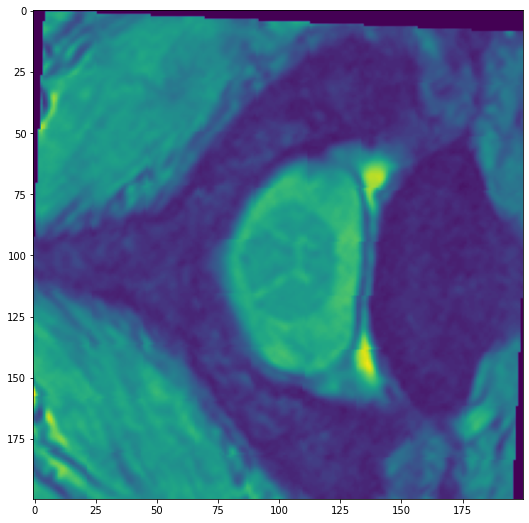

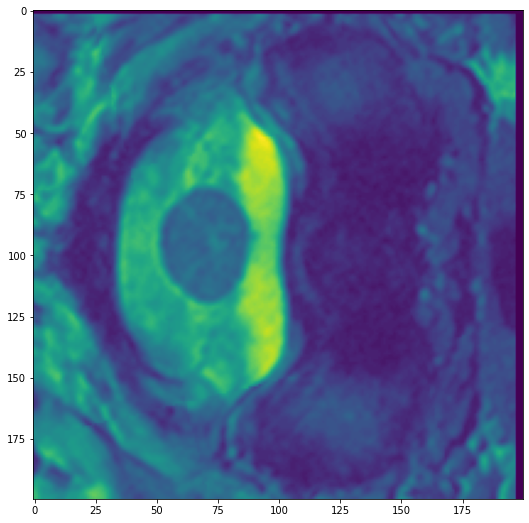

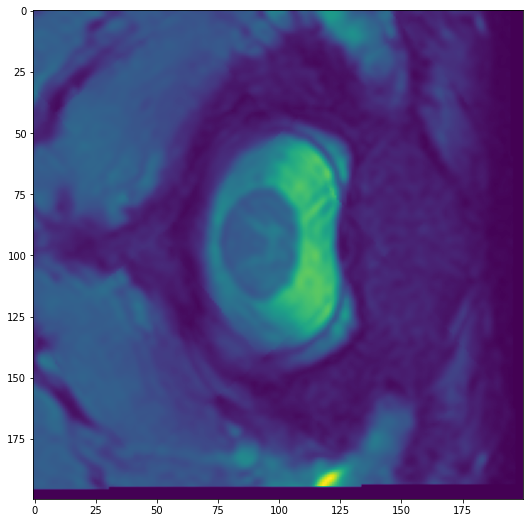

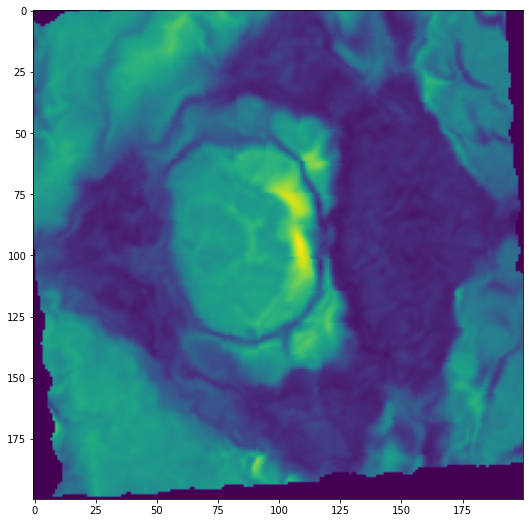

In [16]:
for item in minibatch['input']:
    plt.imshow(item.squeeze(0))
    plt.show()

# Construction d'un modèle de segmentation

Nous avons observé notre jeu de données et crée des data loaders pour importer nos données et pour permettre de les donner en entrée à des algorithmes de deep learning. Nous pouvons maintenant commencer à construire notre modèle et le paramétrer.

### Initialisation du modèle 

**Première étape:** le choix du modèle! Le U-net est un réseau de neurones entièrement à convolutions. Il ne contient que des couches de convolutions associées à des couches de pooling. Développé à l'origine pour la segmenation d'images biomédicales au départemetn d'informatique de l'université de Fribourg en Allemagne, ce réseau et son architecture ont su se faire une place dans la segmentation d'images, un des ses atouts majeurs étant qu'il ne nécessite pas d'un énorme volume d'images pour s'entrainer de facon précise.

![texte alternatif](https://docs.google.com/drawings/d/e/2PACX-1vT2miqwBsJpm9vX2lH7GRJaMWw3ym9Ld3MNY-10rpKIQJoXvfsRbIu1OpndIn4BJqYUtpq3wZcwmS9v/pub?w=921&h=624)

*Architecture du U-net*

In [0]:
model = mt_models.Unet(drop_rate=0.4, bn_momentum=0.1)

**Deuxième étape:** on définit également quelques hyperparamètres pour initialiser et optimiser notre modèle:
- Le nombre d'*epochs*: combien de fois veut on que l’algorithme s’entraine sur notre jeu de données entier? 
- Le *learning rate*: pas de la rétropropagation qui intervient lors
du processus de mise à jour des paramètres selon une fonction de coût à optimiser.
- L'algorithme d'*optimisation* : Dans la plupart des cas, l’algorithme d’optimisation est la descente du gradient. Cependant, il en existe de nombreuses versions : par exemple la descente stochastique du gradient minimise la fonction de coût, et pour chaque itération sélectionne de façon aléatoire un sous échantillon d’entrainement. Le *Adam Optimizer* permet en plus au learning rate de s'adapter à chaque itération.



In [0]:
num_epochs=20
rate=0.01
optimizer = optim.Adam(model.parameters(), lr=rate, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=.3, threshold=1e-4, verbose=True)

### Entrainement et optimisation du modèle

Définissons avant de commencer, une fonction bien utile pour la suite: `get_lr()`. Après chaque *epoch* elle permettra de récupérer le *learning rate* mis à jour.



In [0]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

**Première étape:** la fonction `train_model`. Pour la toute première étape du training, on passe le modèle en mode entrainement, on le bascule vers le GPU s'il est disponnible, et on initialise une liste qui contiendra les *loss* pour chaque sous échantillon du jeu de données. 

On crée ensuite une boucle qui itère sur le data loader (qu'on aura passé en argument à la fonction `train_model`).

A chaque itération: 
- Une image IRM et le masque associé sont passées au GPU
- Le U-net calcule une prédiction: autrement dit il crée un masque de segmentation sur l'image qu'on lui aura fourni
- La loss entre ce masque crée et le véritbal masque est calculée
- La loss est retropropagée et les gradients sont calculés (cf. Etat de l'art 😉)
- Les poids du modèle sont ajustés (c'est l'optimisation du modèle)
- L'accuracy est calculé entre le véritable masque et le masque prédit.

Pour rappel, l'*accuracy* est une mesure d'évaluation d'un classifieur, elle correspond au taux d'instances correctements prédites sur la totalité des prédictions. Dans le cas d'une image, l'*accuracy* compare simplement deux `numpy arrays` entre eux. Pour cela, apres chaque prédictions, on repasse le masque réel eet le masque crée au CPU, et ces derniers sont transformés en *numpy arrays* (tenseurs originellement). 


In [0]:
def train_model(model, train_loader, epoch, num_epochs, optimizer, current_lr, log_every=40):
    _ = model.train()

    if torch.cuda.is_available():
        model.cuda()
    
    losses = []

    for i, batch in enumerate(train_loader):
        image, mask = batch["input"], batch["gt"]
        optimizer.zero_grad()
        
        if torch.cuda.is_available():
        	image = image.cuda()
        	mask = mask.cuda(non_blocking=True)

        prediction = model(image)

        loss = mt_losses.dice_loss(prediction, mask)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        losses.append(loss_value)
       
        mask_npy = mask.cpu().numpy().astype(np.uint8)
        mask_npy = mask_npy.squeeze(axis=1)

        prediction = prediction.data.cpu().numpy().astype(np.uint8)
        prediction = prediction.squeeze(axis=1)

        acc =  mt_metrics.accuracy_score(prediction, mask_npy)

        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Single batch number : {2} / {3} ]| avg train loss {4} | train acc : {5} | lr : {6}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(train_loader),
                      np.round(np.mean(losses), 4),
                      np.round(acc, 4),
                      current_lr
                  )
                  )

    train_loss_epoch = np.round(np.mean(losses), 4)
    train_acc_epoch = np.round(acc, 4)
    return train_loss_epoch, train_acc_epoch

**Deuxième étape:** la fonction `evaluate_model`. Celle ci sera utilisée par la suite pour tester notre modèle sur le dataset de validaton. Elle est très similaire à la fonction `train_model` puisque le principe est le même, la seule différence étant qu'ici on n'optimise pas la *loss* - ou fonction de cout. 

In [0]:
def evaluate_model(model, val_loader, epoch, num_epochs, current_lr, log_every=20):
    _ = model.eval()
    
    if torch.cuda.is_available():
        model.cuda()
        
    losses = []

    for i, batch in enumerate(val_loader):
        image, mask = batch["input"], batch["gt"]
        
        if torch.cuda.is_available():
            image = image.cuda()
            mask = mask.cuda(non_blocking=True)
        
        prediction = model(image)

        loss = mt_losses.dice_loss(prediction, mask)
        loss_value = loss.item()
        losses.append(loss_value)

        
        mask_npy = mask.cpu().numpy().astype(np.uint8)
        mask_npy = mask_npy.squeeze(axis=1)

        prediction = prediction.data.cpu().numpy().astype(np.uint8)
        prediction = prediction.squeeze(axis=1)

        acc =  mt_metrics.accuracy_score(prediction, mask_npy)

        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Single batch number : {2} / {3} ]| avg val loss {4} | val acc : {5} | lr : {6}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(val_loader),
                      np.round(np.mean(losses), 4),
                      np.round(acc, 4),
                      current_lr
                  )
                  )

    val_loss_epoch = np.round(np.mean(losses), 4)
    val_acc_epoch = np.round(acc, 4)
    return val_loss_epoch, val_acc_epoch

**Troisième étape:** la fonction `run`, c'est dans le `run` que l'entrainement a réellement lieu. On crée une boucle qui itère sur le nombre d'*epochs*, et à chaque *epoch*:
- On entraine le modèle en faisant appel à  `train_model()`
- On évalue le modèle en faisant appel à `evaluate_model()`
- On affiche l'*accuracy* et la *loss* sur les jeux de train et test
- Le scheduler met à jour le learning rate
- Le modèle est sauvegardé si l'*accuracy* s'est amélioré

En sortie, fonction `run` renvoie des vecteur contenant les valeurs de la *loss* et de l'*accuracy* pour le train et la validation à chaque *epoch*.

In [0]:
def run(model, train_loader, validation_loader, prefix_name, epochs, lr,  save_model):
        
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    if torch.cuda.is_available():
        model = model.cuda()

    best_val_loss = float('inf')
    best_val_acc = float(0)

    num_epochs = epochs
    iteration_change_loss = 0

    t_start_training = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(optimizer)

        t_start = time.time()
        
        train_loss, train_acc = train_model(
            model, train_loader, epoch, num_epochs, optimizer, current_lr)
        val_loss, val_acc = evaluate_model(
            model, validation_loader, epoch, num_epochs, current_lr)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        t_end = time.time()
        delta = t_end - t_start

        print("train loss : {0} | train accuracy {1} | val loss {2} | val accuracy {3} | elapsed time {4} s".format(
            train_loss, train_acc, val_loss, val_acc, delta))

        iteration_change_loss += 1
        print('-' * 30)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if bool(save_model):
                file_name = f'model_{prefix_name}_val_acc_{val_acc:0.4f}_epoch_{epoch+1}.pth'
                for f in os.listdir('/content/gdrive/My Drive/Medical/TPT/models/'):
                        os.remove(f'/content/gdrive/My Drive/Medical/TPT/models/{f}')
                torch.save(model, f'/content/gdrive/My Drive/Medical/TPT/models/{file_name}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            iteration_change_loss = 0

        if iteration_change_loss == 5:
            print('Early stopping after {0} iterations without the decrease of the val loss'.
                  format(iteration_change_loss))
            break

    t_end_training = time.time()
    print(f'training took {t_end_training - t_start_training} s')
    return train_losses, val_losses, train_accs, val_accs

Testons notre modèle! Cela risque de prendre un moment... Moment parfait pour faire une pause et aller se chercher un café! ☕

In [25]:
train_losses, val_losses, train_accs, val_accs = run(model=model, train_loader=train_loader, validation_loader=val_loader, prefix_name='test', epochs=num_epochs, lr=rate,  save_model=0)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[Epoch: 1 / 20 |Single batch number : 40 / 356 ]| avg train loss -0.1598 | train acc : 96.6512 | lr : 0.01
[Epoch: 1 / 20 |Single batch number : 80 / 356 ]| avg train loss -0.1489 | train acc : 96.4844 | lr : 0.01
[Epoch: 1 / 20 |Single batch number : 120 / 356 ]| avg train loss -0.1514 | train acc : 96.6225 | lr : 0.01
[Epoch: 1 / 20 |Single batch number : 160 / 356 ]| avg train loss -0.1503 | train acc : 95.9606 | lr : 0.01
[Epoch: 1 / 20 |Single batch number : 200 / 356 ]| avg train loss -0.1501 | train acc : 96.1175 | lr : 0.01
[Epoch: 1 / 20 |Single batch number : 240 / 356 ]| avg train loss -0.1484 | train acc : 96.4475 | lr : 0.01
[Epoch: 1 / 20 |Single batch number : 280 / 356 ]| avg train loss -0.1447 | train acc : 96.3925 | lr : 0.01
[Epoch: 1 / 20 |Single batch number : 320 / 356 ]| avg train loss -0.1436 | train acc : 96.3013 | lr : 0.01
[Epoch: 1 / 20 |Single batch number : 20 / 111 ]| avg val loss -0.1036 | val acc : 97.505 | lr : 0.01
[Epoch: 1 / 20 |Single batch number 

### Evaluation des performances du modèle

Lorsque le modèle a fini de s'entrainer, il renvoie les vecteurs contenant les valeurs de la *loss* et de l'*accuracy* à chaque epoch. Traçons les pour observer leur évolution. Commençons par les *accuracy* sur le dataset de train et le dataset de validation. 

Text(0.5, 0.98, "Evolution de l'accuracy")

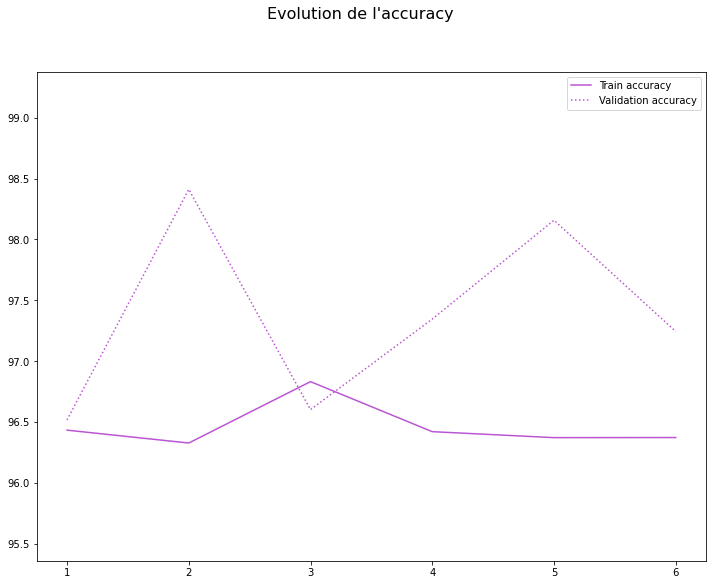

In [30]:
x = np.arange(1, 7) #car le modèle s'est arreté après 6 epochs
fig, ax = plt.subplots()
ax.plot(x, train_accs, 'mediumorchid',linestyle = '-', label='Train accuracy')
ax.plot(x, val_accs, 'mediumorchid', linestyle=':', label='Validation accuracy')
ax.axis('equal')
leg = ax.legend();
fig.suptitle("Evolution de l'accuracy", fontsize=16)

Observons maintenant l'évolution de la *loss* ou fonction de cout, celle ci est très importante. En effet, si on observe que la fonction de cout n'a pas convergé et ne s'est pas stabilisé, cela veut dire que notre modèle n'est pas optimal! 

Dans ce cas là, une première approche possible pour y remédier serait d'augmenter le nombre d'époch pour lui laisser la possibilité de converger. Ou bien encore, une autre approche peut etre de changer le *learning rate* initial. 

Text(0.5, 0.98, 'Evolution de la fonction de cout')

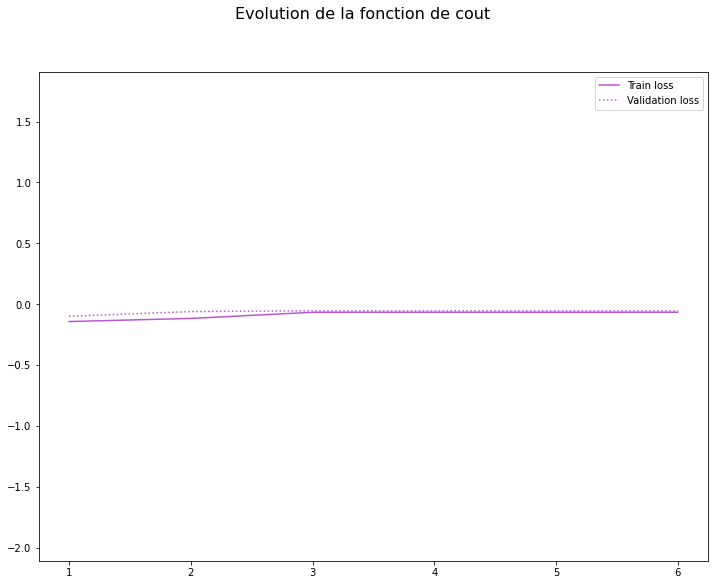

In [31]:
fig, ax = plt.subplots()
ax.plot(x, train_losses, 'mediumorchid', linestyle='-', label='Train loss')
ax.plot(x, val_losses, 'mediumorchid',linestyle=':', label='Validation loss')
ax.axis('equal')
leg = ax.legend();
fig.suptitle('Evolution de la fonction de cout', fontsize=16)

# Conclusion 

Et voilà! 

Nous avons appris à lire des images IRM, à les prétraiter et à les charger en utilisant `medicaltorch` et le `DataLoader` de `PyTorch`! Nous avons surtout appris à créer un super modèle basée sur les CNN, et à entrainer et optimiser un réseau de neurones. 

Merci de votre attention! 👋


